# Project 2: Graphical Models and VI

## Part 1: Image De-Noising Using Markov Random Fields

(256, 256, 4)
(256, 256)


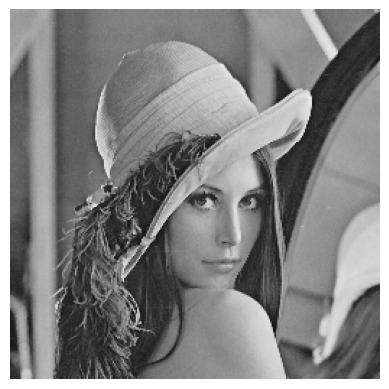

[[0.6313726  0.6313726  0.6156863  ... 0.6627451  0.6627451  0.49411765]
 [0.6313726  0.6313726  0.6156863  ... 0.67058825 0.6627451  0.49411765]
 [0.6392157  0.60784316 0.62352943 ... 0.58431375 0.4862745  0.24313726]
 ...
 [0.21176471 0.18039216 0.20392157 ... 0.34509805 0.36078432 0.3529412 ]
 [0.16470589 0.18039216 0.18039216 ... 0.3764706  0.40784314 0.38431373]
 [0.17254902 0.19607843 0.18039216 ... 0.40784314 0.40784314 0.42352942]]


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

lena = mpimg.imread("Image/Lena-8-bit.png")
print(lena.shape)


# # verification if the image is really a grayscale one
# identical_channels = (lena[:,:,0] == lena[:,:,1]).all() and (lena[:,:,0] == lena[:,:,2]).all()
# if identical_channels:
#     print("The RGB channels are identical. The image is effectively grayscale with an alpha channel.")
# else:
#     print("The RGB channels are not identical.")

# Change the format from RGBA to grayscale
grayscale_lena = lena[:,:,0]
print(grayscale_lena.shape)


def plot(image):
    plt.imshow(image,cmap = 'gray')
    plt.axis('off');
    plt.show()

plot(grayscale_lena)
print(grayscale_lena)

### Creation of the noisy image

In [6]:
# Creation of the Gaussiann noise
mean, var = 0, 0.05
gauss = np.random.normal( loc=mean, scale=var, size=(256,256) )

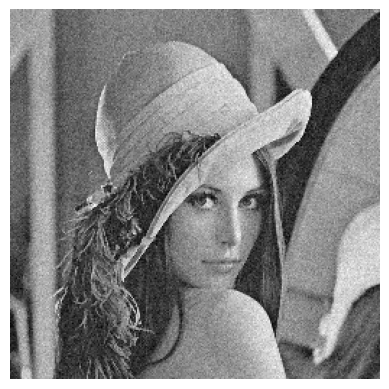

256
[[0.65368662 0.65958414 0.65917991 ... 0.62650609 0.57180958 0.52118317]
 [0.57380936 0.64112614 0.61739825 ... 0.6641576  0.71186488 0.50263662]
 [0.66204652 0.59154532 0.61973092 ... 0.6000076  0.48380901 0.23838931]
 ...
 [0.14688978 0.21998803 0.17640524 ... 0.35138372 0.33376177 0.3748228 ]
 [0.11574099 0.12124682 0.126819   ... 0.35821104 0.29734554 0.43549701]
 [0.15115443 0.150915   0.19283311 ... 0.36460652 0.45107136 0.39713141]]


In [7]:
# Noisy picture
noisy_lena = grayscale_lena + gauss
noisy_lena = np.clip(noisy_lena, 0, 1) # To avoid going out of the range
plot(noisy_lena)
print(len(noisy_lena))
print(noisy_lena)

### Technique: Iterated conditional modes (ICM)

#### Extented version for 8-bit images

##### Energy function

In [4]:
def energy_function(img, noisy_img,h=1,beta=1,eta=1):
    
    bias_term = h * np.sum(img)

    beta_term = 0
    row, column = img.shape

    for i in range(row):
        for j in range(column):
            if i > 0:
                beta_term += img[i,j] * img[i-1,j]
            if i < row - 1:
                beta_term += img[i,j] * img[i+1,j]
            if j > 0:
                beta_term += img[i,j] * img[i,j-1]
            if j < column -1:
                beta_term += img[i,j] * img [i,j+1]
    beta_term = beta * beta_term

    eta_term = -1 * eta * np.multiply(img, noisy_img)
    eta_term = np.sum(eta_term)



    return bias_term - (beta_term + eta_term)

In [5]:
def optimized_energy_function(img, noisy_img, h=0, beta=1, eta=1):

    # Bias term
    bias_term = h * np.sum(img)

    # Beta term
    # Calculate for all neighboring pixels and sum them up

    # Vertical neighbors
    beta_term = np.sum(img[:-1, :] * img[1:, :])  # from current pixel to the one below
    beta_term += np.sum(img[1:, :] * img[:-1, :])  # from current pixel to the one above

    # Horizontal neighbors
    beta_term += np.sum(img[:, :-1] * img[:, 1:])  # from current pixel to the right
    beta_term += np.sum(img[:, 1:] * img[:, :-1])  # from current pixel to the left

    beta_term *= beta

    # Eta term
    eta_term = -1 * eta * np.sum(img * noisy_img)

    return bias_term - (beta_term + eta_term)

##### ICM algorithm

In [6]:
import time
def icm (noisy_img,epochs=10,step=0.05):

    # Initialisation
    de_noised_img_estimate = noisy_img.copy()

    row, column = noisy_img.shape
    for _ in range(epochs):

        print("epochs: ",_)
        start_time = time.time()

        for i in range(row):
            for j in range(column):
                energy = []
                estimate_pixel = de_noised_img_estimate[i,j]
                # values = np.arange(0, 1 + (1/256), 1/256)

                # Optimisation to look just for the near value
                values = np.arange(max(0, estimate_pixel - step),
                                   min(1, estimate_pixel + step) + step,
                                   step)

                # computation of the energie for every possible value
                for value in values:
                    # set the current pixel to the intensity value being evaluated
                    de_noised_img_estimate[i,j] = value
                    energy.append( optimized_energy_function(de_noised_img_estimate,noisy_img))

                de_noised_img_estimate[i,j] = values[np.argmin(energy)]


        end_time = time.time()
        timer = end_time - start_time
        print(f"this epoch last: {timer}")           
    return de_noised_img_estimate

In [7]:
import time

def icm_optimized(noisy_img, epochs=10, step=0.05):
    de_noised_img_estimate = noisy_img.copy()
    row, column = noisy_img.shape
    
    # Using np.nditer for efficient iteration over numpy arrays
    it = np.nditer(noisy_img, flags=['multi_index'])
    for _ in range(epochs):
        it.reset()
        print("epochs: ",_)
        start_time = time.time()
        for x in it:
            i, j = it.multi_index
            estimate_pixel = de_noised_img_estimate[i,j]
            
            # Limit the creation of the values array
            values = np.arange(max(0, estimate_pixel - step),
                               min(1, estimate_pixel + step) + step,
                               step)
            
            energies = []
            for value in values:
                # Temporarily update the pixel value
                de_noised_img_estimate[i,j] = value
                energies.append(optimized_energy_function(de_noised_img_estimate, noisy_img))
                
            # Update the pixel value to the one with the minimum energy
            de_noised_img_estimate[i,j] = values[np.argmin(energies)]

        end_time = time.time()
        timer = end_time - start_time
        print(f"this epoch last: {timer}")        
    return de_noised_img_estimate


##### Error function

In [8]:
def mse_image(real_img,de_noised_img):
    mse = np.sum( (real_img - de_noised_img)**2 )
    return mse / (real_img.shape[0] * real_img.shape[1])

##### V1

In [24]:
de_noised_img = icm(noisy_lena)

epochs:  0
this epoch last: 146.09352922439575
epochs:  1
this epoch last: 175.5263271331787
epochs:  2
this epoch last: 185.16284012794495
epochs:  3
this epoch last: 191.59601855278015
epochs:  4
this epoch last: 184.4401354789734
epochs:  5
this epoch last: 164.37756252288818
epochs:  6
this epoch last: 154.1511459350586
epochs:  7
this epoch last: 153.88477873802185
epochs:  8
this epoch last: 122.81765365600586
epochs:  9
this epoch last: 2386.5948164463043


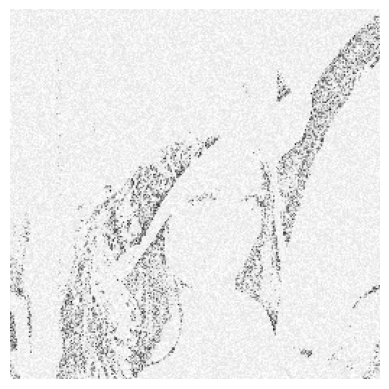

0.3060401427238682


In [30]:
plot(de_noised_img)
print(mse_image(grayscale_lena,de_noised_img))

##### V2

In [12]:
def local_energy(img, noisy_img, i, j, h=0, beta=1, eta=2.1):
    # Compute the energy for a single pixel based on its neighborhood
    row, column = img.shape

    # Bias term
    bias_term = h * img[i, j]

    # Beta term (considering the immediate neighbors)
    beta_term = 0
    for x, y in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
        if 0 <= x < row and 0 <= y < column:
            beta_term += img[i, j] * img[x, y]

    beta_term *= beta

    # Eta term
    eta_term = -1 * eta * img[i, j] * noisy_img[i, j]

    return bias_term - (beta_term + eta_term)

def icm_2(noisy_img, epochs=10, step=0.05):
    # Initialisation
    de_noised_img_estimate = noisy_img.copy()
    row, column = noisy_img.shape

    for _ in range(epochs):
        print("epochs: ", _)
        start_time = time.time()

        for i in range(row):
            for j in range(column):
                current_energy = local_energy(de_noised_img_estimate, noisy_img, i, j)

                # Instead of considering all possible values, let's only check the current, upper and lower bounds
                possible_values = [max(0, de_noised_img_estimate[i,j] - step), de_noised_img_estimate[i,j], min(1, de_noised_img_estimate[i,j] + step)]
                energies = []

                for value in possible_values:
                    de_noised_img_estimate[i, j] = value
                    energies.append(local_energy(de_noised_img_estimate, noisy_img, i, j))

                # Set the pixel to the value with the lowest energy
                de_noised_img_estimate[i, j] = possible_values[np.argmin(energies)]

        end_time = time.time()
        print(f"This epoch lasted: {end_time - start_time}")

    return de_noised_img_estimate

epochs:  0
This epoch lasted: 1.9013502597808838
epochs:  1
This epoch lasted: 1.7541790008544922
epochs:  2
This epoch lasted: 1.6856188774108887
epochs:  3
This epoch lasted: 1.8382127285003662
epochs:  4
This epoch lasted: 1.6379969120025635
epochs:  5
This epoch lasted: 1.6812403202056885
epochs:  6
This epoch lasted: 1.8513996601104736
epochs:  7
This epoch lasted: 1.6370601654052734
epochs:  8
This epoch lasted: 1.835357904434204
epochs:  9
This epoch lasted: 1.930429220199585


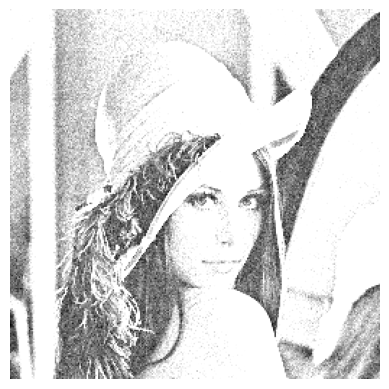

MSE:  0.19260510389813149


In [13]:
de_noised_img = icm_2(noisy_lena)
plot(de_noised_img)
print("MSE: ",mse_image(grayscale_lena,de_noised_img))

##### V3

In [18]:
def E_generator(alpha, beta, gamma):

        def E(x, y):
                xxm = np.zeros_like(x)
                xxm[:-1, :] = x[1:, :]  # down
                xxm[1:, :] += x[:-1, :]  # up
                xxm[:, :-1] += x[:, 1:]  # right
                xxm[:, 1:] += x[:, :-1]  # left
                xx = np.sum(xxm * x)
                xy = np.sum(x * y)
                xsum = np.sum(x)

                return alpha * xsum - beta * xx - gamma * xy
        
        def is_valid(i, j, shape):
                # Checking validity of coordinates i, j in shape
                return i >= 0 and j >= 0 and i < shape[0] and j < shape[1]

        def localized_E(E1, i, j, x, y):
                
                old_val = x[i, j]
                new_val = old_val * -1  # flip
                # local computations
                E2 = E1 - (alpha * old_val) + (alpha * new_val)
                E2 = E2 + (gamma * y[i, j] * old_val) - (gamma * y[i, j] * new_val)
                adjacent = [(0, 1), (0, -1), (1, 0), (-1, 0)]
                neighbors = [x[i + di, j + dj] for di, dj in adjacent if is_valid(i + di, j + dj, x.shape)]
                E2 = E2 + beta * sum(a * old_val for a in neighbors)
                E2 = E2 - beta * sum(a * new_val for a in neighbors)

                return old_val, new_val, E1, E2
        
        return E, localized_E


def denoise(y, E, localized_E):
        # init
        x = np.array(y)
        Ebest = Ecur = E(x, y)  # initial energy
        initial_time = time.time()
        energy_record = [[0.0, ], [Ebest, ]]

        for idx in np.ndindex(y.shape):  # for each pixel in the matrix
                old, new, E1, E2 = localized_E(Ecur, idx[0], idx[1], x, y)
                if (E2 < Ebest):
                        Ecur, x[idx] = E2, new
                        Ebest = E2  # update Ebest
                else:
                        Ecur, x[idx] = E1, old

                if idx[1] == y.shape[1] - 1:
                        # recording time and Ebest of this iteration
                        used_time = time.time() - initial_time
                        energy_record[0].append(used_time)
                        energy_record[1].append(Ebest)


        return x, energy_record

Text(0.5, 1.0, 'Denoised Image')

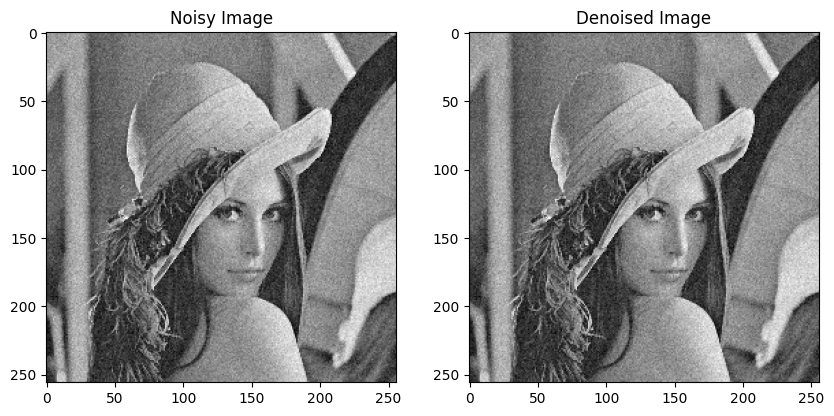

In [19]:
E, localized_E = E_generator(0, 2.1e-3, 1e-3)
result, energy_record = denoise(noisy_lena, E, localized_E)

fig=plt.figure(figsize=(10, 10, ))
fig.add_subplot(2, 2, 1)   # subplot one
plt.imshow(noisy_lena, cmap='gray')
plt.title('Noisy Image')

fig.add_subplot(2, 2, 2)   # subplot two
plt.imshow(result, cmap='gray')
plt.title('Denoised Image')

## Part 2: Image De-noising Using the SP/MS Algorithm

### Creation of the graphical model for the SP algortihm

In [9]:
# Graphical model of the image
# o-o-o
#     |
# o-o-o
# |
# o-o-o

import numpy as np

class GraphicalModel:
    def __init__(self, original_image, noisy_image):
        self.original_image = original_image
        self.noisy_image = noisy_image
        self.shape = noisy_image.shape
        self.normalisation = 0


    def get_neighbors(self, i, j):
        """
        Get neighbors for pixel at (i, j).
        """

       # Check if the input indices are out of bounds
        if i < 0 or i >= self.shape[0] or j < 0 or j >= self.shape[1]:
          return []

        neighbors = []

        # Check horizontal neighbors within column bounds
        if j > 0:
          neighbors.append((i, j-1))
        if j < self.shape[1] - 1:
          neighbors.append((i, j+1))

        # Check vertical neighbors within row bounds
        if i < self.shape[0] - 1:
          if i % 2 == 0:
            if j == 0 and i > 0:
              neighbors.append((i-1, j))
            if j == self.shape[1] - 1:
              neighbors.append((i+1, j))
          if i % 2 == 1:
            if j == self.shape[1]-1:
              neighbors.append((i-1, j))
            if j == 0:
              neighbors.append((i+1, j))
        return neighbors



    def noise_factor(self, noisy_pixel, original_pixel, mean=0, var=0.05):

      sigma = np.sqrt(var)
      coefficient = 1 / (sigma * np.sqrt(2 * np.pi))
      noise_value = noisy_pixel - original_pixel
      exponent = -((noise_value - mean)**2) / (2 * var)

      return coefficient * np.exp(exponent)


    def pairwise_factor(self, x1, x2, beta=1):
      factor = -1 * beta * x1 * x2

      return np.exp(factor)


    def define_normalisation(self, beta):
      normalisation_constant = 0
      for i in range(256):
        for j in range(256):
          normalisation_constant += np.exp(-1 * beta * i * j)

      self.normalisation = normalisation_constant


    def forward_pass(self):
        messages = []

        # Initialize the first message using only the local evidence
        likelihood = np.array([self.noise_factor(self.noisy_image[0, 0], k) for k in range(256)])
        messages.append(likelihood)

        # Cache the pairwise potentials for all possible combinations of pixel intensities
        pairwise_cache = np.array([[self.pairwise_factor(l, k) for l in range(256)] for k in range(256)])

        # Iterate through the chain and propagate messages
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                if (i == 0 and j == 0):  # skip the first node, already initialized
                    continue

                neighbors = self.get_neighbors(i, j)
                prev_node = neighbors[0]
                prev_node_i, prev_node_j = prev_node
                prev_intensity = int(self.noisy_image[prev_node_i, prev_node_j])

                # Compute message using matrix operations
                message_from_prev = messages[-1] @ pairwise_cache[prev_intensity]

                # Normalize the message
                message_from_prev /= message_from_prev.sum()

                # Multiply the message by the local evidence
                likelihood = np.array([self.noise_factor(self.noisy_image[i, j], k) for k in range(256)])
                current_message = likelihood * message_from_prev

                # Normalize the current message
                current_message /= current_message.sum()

                messages.append(current_message)

        return messages



    def backward_pass(self):
        messages_backward = [np.ones(256) / 256 for _ in range(self.shape[0] * self.shape[1])]

        # Cache the pairwise potentials for all possible combinations of pixel intensities
        pairwise_cache = np.array([[self.pairwise_factor(k, l) for l in range(256)] for k in range(256)])

        # Start from the end of the chain and move to the beginning
        for i in range(self.shape[0]-1, -1, -1):
            for j in range(self.shape[1]-1, -1, -1):
                # Skip the last node, as it has already been initialized
                if (i == self.shape[0] - 1 and j == self.shape[1] - 1):
                    continue

                neighbors = self.get_neighbors(i, j)
                next_node = None
                for neighbor in neighbors:
                    ni, nj = neighbor
                    if (ni > i) or (ni == i and nj > j):  # find the "next" neighbor in the chain
                        next_node = neighbor
                        break

                if not next_node:
                    continue  # if no "next" neighbor, skip this iteration

                next_intensity = int(self.noisy_image[next_node[0], next_node[1]])
                message_from_next = pairwise_cache[next_intensity] @ messages_backward[next_node[0] * self.shape[1] + next_node[1]]

                # Normalize the message
                message_from_next /= message_from_next.sum()

                # Multiply the message by the local evidence
                likelihood = np.array([self.noise_factor(self.noisy_image[i, j], k) for k in range(256)])
                current_message = likelihood * message_from_next

                # Normalize the current message
                current_message /= current_message.sum()

                messages_backward[i * self.shape[1] + j] = current_message

        return messages_backward




    def compute_beliefs(self):
        forward_messages = self.forward_pass()
        backward_messages = self.backward_pass()

        beliefs = []

        # For each node, multiply the incoming forward and backward messages
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                linear_idx = i * self.shape[1] + j
                belief = forward_messages[linear_idx] * backward_messages[linear_idx]

                # Normalize the belief
                belief /= belief.sum()
                beliefs.append(belief)

        return beliefs



    def estimate_image(self):
      beliefs = self.compute_beliefs()
      estimated_image = np.zeros(self.shape, dtype=int)

      for i in range(self.shape[0]):
        for j in range(self.shape[1]):
          estimated_image[i, j] = np.argmax(beliefs[i * self.shape[1] + j])

      return estimated_image


    def iterative_refinement(self, iterations=5):
      estimated_image = self.noisy_image.copy()  # Start with the noisy image

      for _ in range(iterations):
          print("epoch: ",_)
          self.noisy_image = estimated_image  # Use the estimated image as the new observation
          estimated_image = self.estimate_image()  # Run belief propagation

      return estimated_image

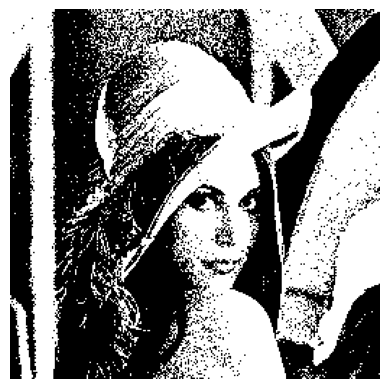

In [8]:
gm = GraphicalModel(lena,noisy_lena)
gm.define_normalisation(1)
# temp = gm.iterative_refinement()
denoise = gm.estimate_image()
plot(denoise)